In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import cv2
import glob
from pathlib import Path
from imutils import paths
import pickle
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/vehicle_detection/hj3vvx5946-1.zip -d /content/

**HYPER PARAMETER**

In [4]:
image_shape = (128, 128, 3)
BATCH_SIZE = 64
EPOCHS = 100

**Helper Function**

In [5]:
def _image_read(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
  
def _save_pickle(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
  return obj

In [5]:
ROOT_DIR = os.path.join(os.path.dirname(os.path.abspath(os.curdir)),'content')
DATA_DIR = Path(ROOT_DIR)/'hj3vvx5946-1/Splited_dataset'
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'

In [6]:
image_links = list(paths.list_images(TRAIN_DIR))

In [31]:
def make_dataset(dir):
    image_links = list(paths.list_images(dir))
    y = []
    x = []
    image_lst = []

    for image_link in image_links:
        split_img_links = image_link.split("/")
        name = split_img_links[-2] 
        image = _image_read(image_link)
        image = cv2.resize(image, (128,128))

        x.append(image)
        y.append(name)
        image_lst.append(image_link)

        y_unique = np.unique(np.array(y))
        if len(y_unique) == 21:
          x = x[:-1]
          y = y[:-1]
          image_lst = image_lst[:-1]

          break

    return x,y,image_lst

In [32]:
x_train,y_train,train_links = make_dataset(TRAIN_DIR)

In [33]:
x_test,y_test,test_links = make_dataset(TEST_DIR)

In [36]:
pickle_path = "/content/drive/MyDrive/vehicle_detection/pickle"

_save_pickle(x_train, pickle_path + "/x_train.pkl")
_save_pickle(y_train, pickle_path + "/y_train.pkl")
_save_pickle(train_links, pickle_path + "/train_links.pkl")

_save_pickle(x_test, pickle_path + "/x_test.pkl")
_save_pickle(y_test, pickle_path + "/y_test.pkl")
_save_pickle(test_links, pickle_path + "/test_links.pkl")

In [37]:
pickle_path = "/content/drive/MyDrive/vehicle_detection/pickle"

x_train = _load_pickle(pickle_path + "/x_train.pkl")
y_train = _load_pickle(pickle_path + "/y_train.pkl")
x_test = _load_pickle(pickle_path + "/x_test.pkl")
y_test = _load_pickle(pickle_path + "/y_test.pkl")

In [38]:
len(x_train)

1381

**Label data**

In [39]:
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

In [40]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [41]:
def make_pairs(images, labels):
    pairImages = []
    pairLabels = []
    
    numClasses = len(np.unique(labels))
    labels_text = np.unique(labels)
    idx = [np.where(labels == labels_text[i])[0] for i in range(0, numClasses)]
    idx = {label : lst for (label,lst) in zip(labels_text,idx)}
    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
      
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
      
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    return (np.array(pairImages), np.array(pairLabels))

In [42]:
(pairTrain, labelTrain) = make_pairs(x_train, y_train)
(pairTest, labelTest) = make_pairs(x_test, y_test)

In [43]:
pickle_path = "/content/drive/MyDrive/vehicle_detection/pickle"
_save_pickle(pairTrain, pickle_path + "/pairTrain.pkl")
_save_pickle(labelTrain, pickle_path + "/labelTrain.pkl")
_save_pickle(pairTest, pickle_path + "/pairTest.pkl")
_save_pickle(labelTest, pickle_path + "/labelTest.pkl")

In [6]:
pickle_path = "/content/drive/MyDrive/vehicle_detection/pickle"
pairTrain = _load_pickle(pickle_path + "/pairTrain.pkl")
labelTrain = _load_pickle(pickle_path + "/labelTrain.pkl")
pairTest = _load_pickle(pickle_path + "/pairTest.pkl")
labelTest = _load_pickle(pickle_path + "/labelTest.pkl")

**Build model**

In [7]:
def build_siamese_model(inputShape, embeddingDim=48):
    # specify the inputs for the feature extractor network
    inputs = tf.keras.layers.Input(inputShape)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = tf.keras.layers.Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # second set of CONV => RELU => POOL => DROPOUT layers
    x = tf.keras.layers.Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # prepare the final outputs
    pooledOutput = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(embeddingDim)(pooledOutput)
    # build the model
    model = tf.keras.models.Model(inputs, outputs)
    # return the model to the calling function
    return model

In [8]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors

    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

**model**

In [9]:
imgA = tf.keras.layers.Input(image_shape)
imgB = tf.keras.layers.Input(image_shape)

featureExtractor = build_siamese_model(image_shape)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(distance)
model = tf.keras.models.Model(inputs=[imgA, imgB], outputs=outputs)

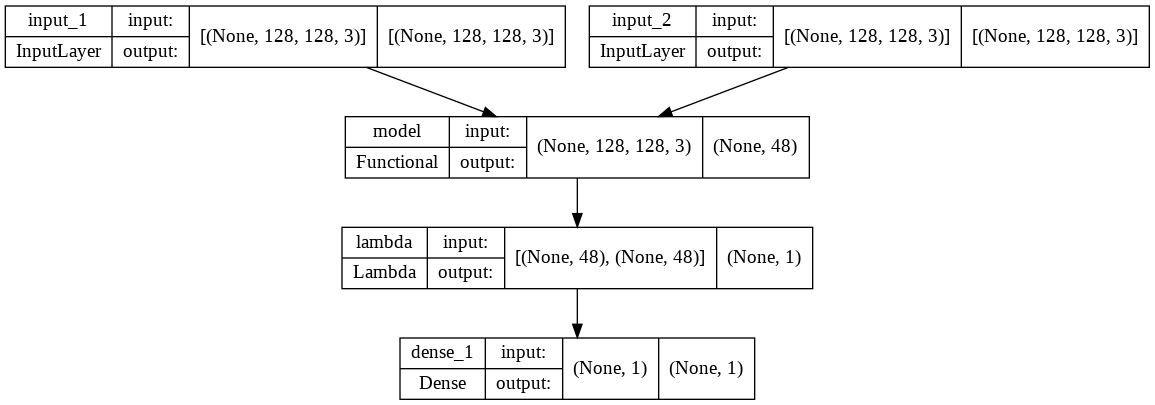

In [62]:
plot_model(model,show_shapes=True)

In [35]:
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=20,
                                                      mode='min',
                                                      restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/vehicle_detection/checkpoint', monitor='val_loss', save_best_only=True, save_feq='epoch')

model.compile(loss='binary_crossentropy', optimizer="adam",metrics=["accuracy"])

history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size= BATCH_SIZE, 
	epochs= EPOCHS,
  callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
43/44 [============================>.] - ETA: 0s - loss: 0.5826 - accuracy: 0.6980

INFO:tensorflow:Assets written to: /content/drive/MyDrive/vehicle_detection/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/vehicle_detection/checkpoint/assets


44/44 [==============================] - 8s 174ms/step - loss: 0.5824 - accuracy: 0.6991 - val_loss: 0.6400 - val_accuracy: 0.6265
Epoch 2/100
44/44 [==============================] - 5s 115ms/step - loss: 0.5737 - accuracy: 0.7104 - val_loss: 0.6429 - val_accuracy: 0.6131
Epoch 3/100
44/44 [==============================] - 5s 114ms/step - loss: 0.5771 - accuracy: 0.6919 - val_loss: 0.6508 - val_accuracy: 0.6012
Epoch 4/100
44/44 [==============================] - 5s 116ms/step - loss: 0.5713 - accuracy: 0.6973 - val_loss: 0.6531 - val_accuracy: 0.6146
Epoch 5/100
44/44 [==============================] - 5s 112ms/step - loss: 0.5780 - accuracy: 0.6962 - val_loss: 0.6434 - val_accuracy: 0.6146
Epoch 6/100
44/44 [==============================] - 5s 112ms/step - loss: 0.5736 - accuracy: 0.6955 - val_loss: 0.6469 - val_accuracy: 0.6161
Epoch 7/100
44/44 [==============================] - 5s 112ms/step - loss: 0.5758 - accuracy: 0.6966 - val_loss: 0.6454 - val_accuracy: 0.6101
Epoch 8/100

INFO:tensorflow:Assets written to: /content/drive/MyDrive/vehicle_detection/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/vehicle_detection/checkpoint/assets


44/44 [==============================] - 6s 133ms/step - loss: 0.5626 - accuracy: 0.7143 - val_loss: 0.6392 - val_accuracy: 0.6205
Epoch 20/100
44/44 [==============================] - 5s 110ms/step - loss: 0.5597 - accuracy: 0.7082 - val_loss: 0.6529 - val_accuracy: 0.6057
Epoch 21/100
44/44 [==============================] - 5s 110ms/step - loss: 0.5769 - accuracy: 0.6875 - val_loss: 0.6418 - val_accuracy: 0.6250
Epoch 22/100
44/44 [==============================] - 5s 111ms/step - loss: 0.5620 - accuracy: 0.7038 - val_loss: 0.6396 - val_accuracy: 0.6176
Epoch 23/100
44/44 [==============================] - 5s 110ms/step - loss: 0.5603 - accuracy: 0.7161 - val_loss: 0.6455 - val_accuracy: 0.6161
Epoch 24/100
44/44 [==============================] - 5s 110ms/step - loss: 0.5679 - accuracy: 0.7006 - val_loss: 0.6436 - val_accuracy: 0.6131
Epoch 25/100
44/44 [==============================] - 5s 110ms/step - loss: 0.5624 - accuracy: 0.7035 - val_loss: 0.6470 - val_accuracy: 0.6250
Epoch

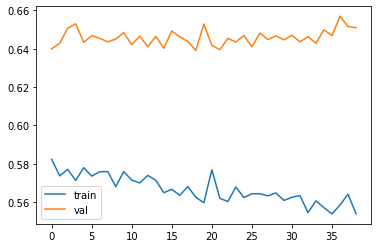

In [50]:
plt.plot(history.history['loss'], label= 'train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

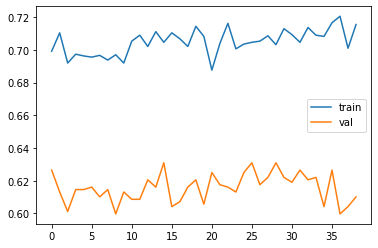

In [51]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

**TEST PAIR IMAGES**

In [69]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 48)           20400       ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [88]:
def predict_similarity(image1_path,image2_path):
    imageA = _image_read(image1_path)
    imageB = _image_read(image2_path)

    origA = imageA.copy()
    origB = imageB.copy()

    imageA = cv2.resize(imageA, (128,128))
    imageB = cv2.resize(imageB, (128,128))
    
    
    imageA = np.expand_dims(imageA, axis=0)
    imageB = np.expand_dims(imageB, axis=0)

    imageA = imageA / 255.0
    imageB = imageB / 255.0
    
    preds = model.predict([imageA, imageB])
    proba = preds[0][0]

    fig = plt.figure("Pair", figsize=(4, 2))
    plt.suptitle("Distance: {:.2f}".format(proba))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(origA, cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(origB, cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()

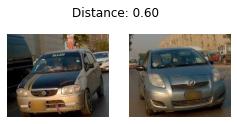

In [89]:
#==================================PAIR 1========================================
image1_path = "/content/drive/MyDrive/vehicle_detection/test_pair/pair1/10235.jpg"
image2_path = "/content/drive/MyDrive/vehicle_detection/test_pair/pair1/13398.jpg"

predict_similarity(image1_path,image2_path)

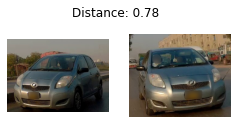

In [90]:
#==================================PAIR 2========================================
image1_path = "/content/drive/MyDrive/vehicle_detection/test_pair/pair2/13387.jpg"
image2_path = "/content/drive/MyDrive/vehicle_detection/test_pair/pair2/13398.jpg"

predict_similarity(image1_path,image2_path)

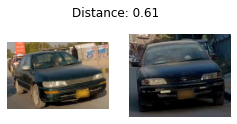

In [91]:
#==================================PAIR 3========================================
image1_path = "/content/drive/MyDrive/vehicle_detection/test_pair/pair3/12932.jpg"
image2_path = "/content/drive/MyDrive/vehicle_detection/test_pair/pair3/25343.jpg"

predict_similarity(image1_path,image2_path)